In [9]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger
from models import ResearchModels
from data import DataSet
from sklearn.metrics import classification_report, confusion_matrix
import random
import numpy as np
import time

batch_size = 8 #32 for LSTM; 8 for CRNN; 5 for CNN-3d

model = 'crnn'  # see `models.py` for more
saved_model = None  # None or weights file
class_limit = None  # int, can be 1-101 or None
seq_length = 90
load_to_memory = True  # pre-load the sequences into memory

# Chose images or features and image shape based on network.
if model == 'conv_3d' or model == 'c3d':
    data_type = 'images'
    #image_shape = (80, 80, 3)
    image_shape = (112, 63, 3) # Work for 3dcnn with batch size 5
    load_to_memory = False
elif model == 'crnn':
    data_type = 'images'
    image_shape = (144, 81, 3) # Work for crnn with batch size 8
    load_to_memory = False
elif model == 'lrcn':
    data_type = 'images'
    image_shape = (144, 81, 3)
    #load_to_memory = False
else:
    data_type = 'features'
    image_shape = None

# MLP requires flattened features.
if model == 'mlp':
    concat = True
else:
    concat = False

In [10]:
%env CUDA_VISIBLE_DEVICES=1
# Get the data and process it.
if image_shape is None:
    data = DataSet(
        seq_length=seq_length,
        class_limit=class_limit
    )
else:
    data = DataSet(
        seq_length=seq_length,
        class_limit=class_limit,
        image_shape=image_shape
    )
    
train, test, validation = data.split_train_test()
steps_per_epoch = len(train) // batch_size
    
if load_to_memory:
    # Get data.
    X_test, y_test = data.get_all_sequences_in_memory('test', data_type, concat)
else:
    # Get generators.
    test_generator = data.frame_generator(batch_size, 'test', data_type, concat)
    
rm = ResearchModels(len(data.classes), model, seq_length, saved_model)
rm.model.load_weights("data/checkpoints/crnn-images.027-0.258.hdf5")
print("Created model and loaded weights from file")

env: CUDA_VISIBLE_DEVICES=1
Loading CRNN model.
Created model and loaded weights from file


In [11]:
from data import DataSet
if load_to_memory:
    # evaluate model
    results = rm.model.evaluate(
        X_test,
        y_test,
        batch_size=batch_size,
        verbose=1)
    print()
    print('Evaluation results on test data is:')
    print(results)
    print(rm.model.metrics_names)

else:
    # Evaluate!
    results = rm.model.evaluate_generator(
        generator=test_generator,
        steps=len(test) // batch_size)
    print()
    print('Evaluation results on test data is:')
    print(results)
    print(rm.model.metrics_names)
print("%s: %.2f%%" % (rm.model.metrics_names[1], results[1]*100))

Creating test generator with 534 samples.

Evaluation results on test data is:
[0.44700732347414351, 0.82954545454545459]
['loss', 'acc']
acc: 82.95%


In [26]:
y_label = [] # Append true label for generator
def frame_generator(batch_size, train_test, data_type, concat=False):
    """Return a generator that we can use to train on. There are
    a couple different things we can return:

    data_type: 'features', 'images'
    """
    # Get the right dataset for the generator.
    train, test, validation = data.split_train_test()
    # data = train if train_test == 'train' else test
    if train_test == 'train':
        dataa = train
    elif train_test == 'test':
        dataa = test
    else:
        dataa = validation

    print("Creating %s generator with %d samples." % (train_test, len(dataa)))

    while 1:
        X, y = [], []

        # Generate batch_size samples.
        for _ in range(batch_size):
            # Reset to be safe.
            sequence = None

            # Get a random sample.
            #sample = data # for confusion matrix
            sample = random.choice(dataa) # for training

            # Check to see if we've already saved this sequence.
            if data_type is "images":
                # Get and resample frames.
                frames = data.get_frames_for_sample(sample)
                frames = data.rescale_list(frames, data.seq_length)

                # Build the image sequence
                sequence = data.build_image_sequence(frames)
            else:
                # Get the sequence from disk.
                sequence = data.get_extracted_sequence(data_type, sample)

            if sequence is None:
                print("Can't find sequence. Did you generate them?")
                sys.exit()  # TODO this should raise

            if concat:
                # We want to pass the sequence back as a single array. This
                # is used to pass into an MLP rather than an RNN.
                sequence = np.concatenate(sequence).ravel()

            X.append(sequence)
            y_label.append(data.get_class_one_hot(sample[1]))

        yield np.array(X), np.array(y)

test_generator = frame_generator(batch_size, 'test', data_type, concat)
if load_to_memory:
    y_pred = rm.model.predict_classes(X_test)
else:
    y_pred_raw = rm.model.predict_generator(
        generator=test_generator,
        steps=len(test) // batch_size)
#print(y_pred_raw)
#print(np.argmax(y_label,axis=1))
print(len(y_label))
print(len(y_pred))

Creating test generator with 534 samples.
[[  2.02841566e-05   9.15782584e-05   1.42847799e-04   9.94871259e-01
    4.69356449e-03   1.80427625e-04]
 [  1.75428540e-05   1.06076397e-04   1.16714313e-04   9.96211529e-01
    3.45308194e-03   9.50809190e-05]
 [  1.37364832e-05   2.00883471e-04   1.74949848e-04   9.96361077e-01
    3.20271635e-03   4.65764533e-05]
 ..., 
 [  1.40528027e-05   8.26085015e-05   4.06363870e-05   9.97385442e-01
    2.43220432e-03   4.50525040e-05]
 [  2.45312312e-05   9.88614338e-05   1.32518879e-03   1.15959416e-03
    5.60370028e-01   4.37021762e-01]
 [  9.99399543e-01   3.91499052e-04   3.38230802e-06   1.52930050e-04
    5.25293144e-05   8.60368914e-08]]
[3 3 3 4 2 0 5 3 2 3 5 2 2 2 3 1 5 2 2 1 0 3 3 0 0 2 3 4 2 3 0 1 2 5 2 5 5
 5 4 3 4 5 3 4 3 2 4 0 0 5 3 0 2 3 5 3 2 3 1 0 1 3 0 2 0 4 2 2 5 5 3 2 2 0
 3 0 5 0 5 0 3 4 3 5 5 3 3 4 1 3 0 2 5 1 1 4 2 3 1 2 4 5 4 3 2 3 4 2 1 2 1
 3 3 2 0 3 0 3 5 0 0 5 3 4 2 2 2 5 3 4 2 4 5 0 0 1 0 2 4 1 1 3 5 0 4 2 4 5
 4 0 3 3

In [29]:
#print (sum(1 for i in y_true if i==1))
y_test = y_label[:528] # 530 for 3dcnn, 528 for crnn
y_pred = y_pred_raw.argmax(axis=-1)
print(confusion_matrix(np.argmax(y_test,axis=1), y_pred))

[[ 96   0   0   0   0   0]
 [  0  41   0   0   0   0]
 [  0  22  90   0   0   0]
 [  0   0   0 130   0   0]
 [  0   0   0   0  33  30]
 [  0   0   0   8  22  56]]


Automatically created module for IPython interactive environment
Confusion matrix, without normalization
[[ 96   0   0   0   0   0]
 [  0  41   0   0   0   0]
 [  0  22  90   0   0   0]
 [  0   0   0 130   0   0]
 [  0   0   0   0  33  30]
 [  0   0   0   8  22  56]]
Normalized confusion matrix
[[ 1.    0.    0.    0.    0.    0.  ]
 [ 0.    1.    0.    0.    0.    0.  ]
 [ 0.    0.2   0.8   0.    0.    0.  ]
 [ 0.    0.    0.    1.    0.    0.  ]
 [ 0.    0.    0.    0.    0.52  0.48]
 [ 0.    0.    0.    0.09  0.26  0.65]]


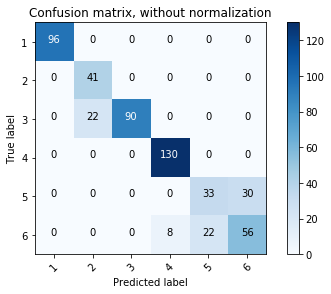

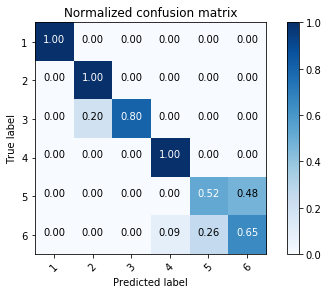

In [30]:
# %matplotlib inline
print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt

# from sklearn import svm, datasets
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import confusion_matrix

# import some data to play with
# iris = datasets.load_iris()
# X = iris.data
# y = iris.target
# class_names = iris.target_names
class_names = ['1', '2', '3', '4', '5', '6']
# class_names = ['1', '2', '3', '4']
# 
# # Split the data into a training set and a test set
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
# 
# # Run classifier, using a model that is too regularized (C too low) to see
# # the impact on the results
# classifier = svm.SVC(kernel='linear', C=0.01)
# y_pred = classifier.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(np.argmax(y_test,axis=1), y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
fig1 = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
fig2 = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [31]:
#fig2.savefig('./cm_lstm.png') # Use fig. here
fig2.savefig('./cm_lstm.png', dpi=1000, bbox_inches='tight') # Better quality and no cropped title